In [1]:
!nvidia-smi

Tue Jun 14 11:01:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    28W /  70W |   1384MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Library

In [2]:
import numpy as np
import random
import os
import math
from itertools import product

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

from torch.autograd import Variable

import torchvision.models as models
from torchvision import transforms

import albumentations as A
import albumentations.pytorch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


# HyperParameter

In [4]:
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':50,
    'PATIENCE':10,
    'class':14
}

# Data Pre-processing

### - DataSet Processing

In [5]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    image_path = os.path.join(data_dir, 'dessert')
    
    for product_name in os.listdir(image_path):
        product_path = os.path.join(image_path, product_name)
        if os.path.isdir(product_path):
            # get image path
            img_path_list.extend(glob(os.path.join(product_path, '*.jpg')))
            img_path_list.extend(glob(os.path.join(product_path, '*.png')))
            label = list(product_name[:5])
            
            # get label
            label_list.append(''.join(label))
                
    return img_path_list, label_list

In [6]:
img_list, label_list = get_train_data('./Data/product_image/Training/')

In [7]:
def data_blanced(img, label):
    x = []
    y = []
    
    for i in range(CFG['class']):
        _img = img[(i * 114): ((i + 1) * 114)]
        _label = label[i]
        
        for img_product in _img:
            x.append(img_product)
            y.append(_label)
            
    return x, y

In [8]:
x, y = data_blanced(img_list, label_list)

In [9]:
# 레이블을 one-hot-vector로 변환
le = preprocessing.LabelEncoder()
targets = le.fit_transform(y)
targets = torch.as_tensor(targets)
one_hot_y = F.one_hot(targets)

In [10]:
one_hot_y.shape

torch.Size([2280, 20])

In [11]:
def get_valid_data(data_dir):
    img_valid_list = []
    label_valid_list = []
    
    image_path = os.path.join(data_dir, 'dessert')
    
    for product_name in os.listdir(image_path):
        product_path = os.path.join(image_path, product_name)
        if os.path.isdir(product_path):
            # get image path
            img_valid_list.extend(glob(os.path.join(product_path, '*.jpg')))
            img_valid_list.extend(glob(os.path.join(product_path, '*.png')))
            label = list(product_name[:5])
            
            # get label
            label_valid_list.append(''.join(label))
                
    return img_valid_list, label_valid_list

In [12]:
def valid_data_blanced(img, label):
    x = []
    y = []
    
    for i in range(CFG['class']):
        _img = img[(i * 15): ((i + 1) * 15)]
        _label = label[i]
        
        for img_product in _img:
            x.append(img_product)
            y.append(_label)
            
    return x, y

In [13]:
img_valid_list, label_valid_list = get_valid_data('./Data/product_image/Validation/')
x_valid, y_valid = valid_data_blanced(img_valid_list, label_valid_list)
len(label_valid_list)

76

In [14]:
le2 = preprocessing.LabelEncoder()
targets_y = le2.fit_transform(y_valid)
targets_y = torch.as_tensor(targets_y)
one_hot_valid_y = F.one_hot(targets_y)
one_hot_valid_y.shape

torch.Size([300, 20])

### - Augmentation

In [15]:
class AlbumentationsCustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.train_mode:
#             image = image.astype(np.int16)
            augmented = self.transforms(image=image)
            image = augmented['image']
            label = self.label_list[index]
            return image, label
        else:
            image = self.transforms(image)
            label = self.label_list[index]
            return image, label
    
    def __len__(self):
        return len(self.img_path_list)

In [16]:
A_train_transform = albumentations.Compose([
                                    A.Resize(256, 256),
                                    A.Normalize(mean=(0.747642, 0.737036, 0.713243), std=(0.1019, 0.121911, 0.169015)),
                                    A.RandomCrop(224, 224),
                                    A.RandomBrightness(limit=0.4, p=0.5),
                                    A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
#                                     A.pytorch.transforms.ToTensor(),
                                    A.pytorch.transforms.ToTensorV2(transpose_mask=True),
                                ])
A_test_transform = albumentations.Compose([
                                    A.Resize(256, 256),
                                    A.Normalize(mean=(0.744859, 0.735139, 0.711357), std=(0.100712, 0.120692, 0.167998)),  
#                                     A.pytorch.transforms.ToTensor(),
                                    A.pytorch.transforms.ToTensorV2(transpose_mask=True),
                                ])

/home/ubuntu/anaconda3/envs/pytorch_16/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [17]:
A_train_dataset = AlbumentationsCustomDataset(x, one_hot_y, train_mode=True, transforms=A_train_transform)
A_train_loader = DataLoader(A_train_dataset, batch_size = 32, shuffle=True, num_workers=0, collate_fn=None)

A_vali_dataset = AlbumentationsCustomDataset(x_valid, one_hot_valid_y, train_mode=True, transforms=A_test_transform)
A_vali_loader = DataLoader(A_vali_dataset, batch_size = 5, shuffle=False, num_workers=0, collate_fn=None)

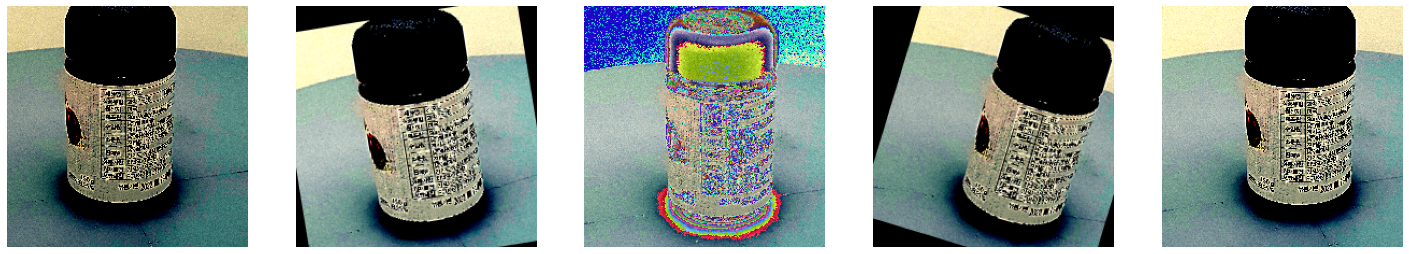

In [18]:
num_samples = 5

fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))

for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(A_train_dataset[0][0]))
    ax[i].axis('off')

### - Tensorboard

In [19]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('./result')

## validation 이미지

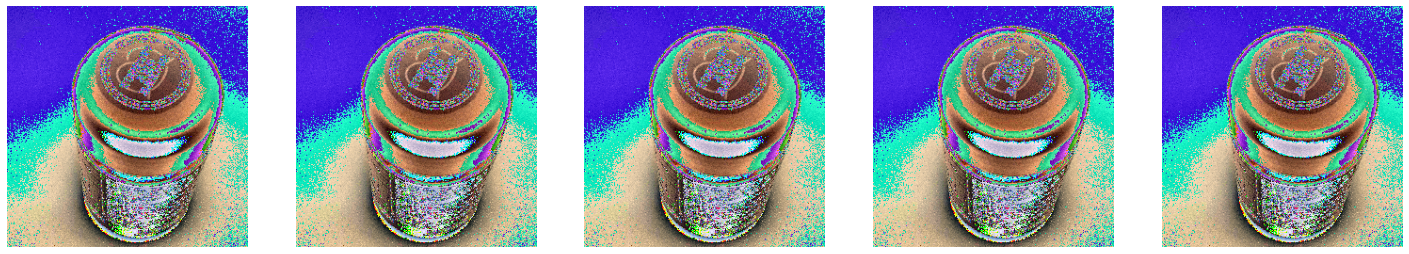

In [20]:
num_samples = 5

fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))

for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(A_vali_dataset[0][0]))
    ax[i].axis('off')

# Models 

### Model definitions

In [21]:
class ResNet50(torch.nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-1]
        self.feature_extract = nn.Sequential(*modules)
        self.fc1 = nn.Linear(2048, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000,CFG['class'])
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.feature_extract(x)
        # x = x.mean(dim=(-2, -1))
        # (batch, 2048, 4, 4)
        x = torch.squeeze(x)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
#         out = self.softmax(x)
        
        return out

In [22]:
class EfficientNetb4(torch.nn.Module):
    def __init__(self):
        super(EfficientNetb4, self).__init__()
        model = models.efficientnet_b4(pretrained=True)
        modules = list(model.children())[:-1]
        self.feature_extract = nn.Sequential(*modules)
        self.fc1 = nn.Linear(1792, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, CFG['class'])
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.feature_extract(x)
        # (batch, 1792, 1, 1)
        x = torch.squeeze(x)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
#         out = self.softmax(x)
        
        return out

In [23]:
class RegNet(torch.nn.Module):
    def __init__(self):
        super(RegNet, self).__init__()
        model = models.regnet_y_16gf(pretrained=True)
        modules = list(model.children())[:-1]
        self.feature_extract = nn.Sequential(*modules)
        self.fc1 = nn.Linear(3024, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, CFG['class'])
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.feature_extract(x)
        # (batch, 3024, 1, 1)
        x = torch.squeeze(x)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
#         out = self.softmax(x)
        
        return out

# Parameters

In [24]:
PARAMS = {
    'models' : ['ResNet50', 'EfficientNetb4', 'RegNet'],
    'learning_rate' : [1e-3, 1e-4, 1e-5],
    'optimizer' : ['adam', 'rmsprop', 'nadam', 'Lamb'],
    'scheduler' : ['CosineAnnealing']
}
hyper_params=list(product(PARAMS['models'], PARAMS['learning_rate'],PARAMS['optimizer'], PARAMS['scheduler']))

In [27]:
def draw_graph(title, loss, valid_loss):
    plt.plot(loss, label="Training Loss")
    plt.plot(valid_loss, label="Validation Loss")
    plt.legend(loc='upper right')
    plt.title(title)
    plt.savefig("./result/loss_chart/" + title + ".png")
    plt.show()

# Train

In [28]:
def validation(model, vali_loader, criterion, device, epoch):
    model.eval() # Evaluation
    vali_loss = []

    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)

            logit = model(img)
            logit = torch.squeeze(logit)
            loss = criterion(logit, label)
            
#             writer.add_scalar("Loss/validation", loss, epoch)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [29]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device, params):
    
    model.to(device)
    epochs = CFG['EPOCHS']
    patience = CFG['PATIENCE']
    
    loss_plot = []
    vali_loss_plot = []
    
    earlystopping = 0

    # Loss Function
    criterion = torch.nn.CrossEntropyLoss()
    best_loss = 9999
    
    print("--------------------------------------------")
    print("model : {}".format(params[0]))
    print("optimizer : {}, learning rate : {}".format(params[2], params[1]))
    print("scheduler : {}".format(params[3]))
    
    for epoch in range(1,epochs+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            logit = torch.squeeze(logit)
            # Calc loss
            loss = criterion(logit, label)
#             writer.add_scalar("Loss/train", loss, epoch)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_loss = validation(model, vali_loader, criterion, device, epoch)
        loss_plot.append(np.mean(train_loss))
        vali_loss_plot.append(vali_loss)
#         title = "{}_{}_{}_{}_epoch_{}_loss".format(params[0], params[1], params[2], params[3], epoch)
#         draw_graph(title, loss_plot, vali_loss_plot)
        print(f'Epoch [{epoch}] Train loss : [{np.mean(train_loss):.5f}] Validation loss : [{vali_loss:.5f}]\n')
        
        # Model Saved
        if best_loss > vali_loss:
            best_loss = vali_loss
            torch.save(model.state_dict(), './saved_models/{}_{}_{}_{}_example.pth'.format(params[0], params[1], params[2], params[3]))
            print('------------------ Model Saved ------------------')
            earlystopping = 0
        elif best_loss <= vali_loss:
            earlystopping += 1
            if earlystopping == patience:
                print("------------stop----------------")
                title = "{}_{}_{}_{}_epoch_{}_loss".format(params[0], params[1], params[2], params[3], epoch)
                draw_graph(title, loss_plot, vali_loss_plot)
                break
                
        if epochs == epoch:
            title = "{}_{}_{}_{}_epoch_{}_loss".format(params[0], params[1], params[2], params[3], epoch)
            draw_graph(title, loss_plot, vali_loss_plot)

### run

In [ ]:
for params in hyper_params:
        
    # model
    if params[0] == 'ResNet50':
        model = ResNet50()
        # optimizer
        if params[2] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=params[1])
        elif params[2] == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=params[1])
        elif params[2] == 'nadam':
            optimizer = torch.optim.NAdam(model.parameters(), lr=params[1])
        elif params[2] == 'Lamb':
            optimizer = optim.Lamb(model.parameters(), lr=params[1], weight_decay=0.0001)
        
    elif params[0] == 'EfficientNetb4':
        model = EfficientNetb4()
            # optimizer
        if params[2] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=params[1])
        elif params[2] == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=params[1])
        elif params[2] == 'nadam':
            optimizer = torch.optim.NAdam(model.parameters(), lr=params[1])
        elif params[2] == 'Lamb':
            optimizer = optim.Lamb(model.parameters(), lr=params[1], weight_decay=0.0001)
        
    elif params[0] == 'RegNet':
        model = RegNet()
        if params[2] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=params[1])
        elif params[2] == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=params[1])
        elif params[2] == 'nadam':
            optimizer = torch.optim.NAdam(model.parameters(), lr=params[1])
        elif params[2] == 'Lamb':
            optimizer = optim.Lamb(model.parameters(), lr=params[1], weight_decay=0.0001)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0, verbose=True)
    train(model, optimizer, A_train_loader, A_vali_loader, scheduler, device, params)

# Inference

In [ ]:
# def predict(model, test_loader, device):
#     model.eval()
#     model_pred = []
#     with torch.no_grad():
#         for img, label in tqdm(iter(test_loader)):
#             img = img.float().to(device)
            
#             pred_logit = model(img)
#             pred_logit = pred_logit.squeeze().detach().cpu()
            
#             model_pred.extend(pred_logit.tolist())
#     return model_pred

In [ ]:
# # pth 파일명
# saved_model = 'RegNet_0.001_Lamb_CosineAnnealing_example.pth'

# # 사용한 모델명
# # model_name = 'resnet'
# # model_name = 'efficientnet'
# model_name = 'regnet'

In [ ]:
# checkpoint = torch.load('./saved_models/' + saved_model)

In [ ]:
# if model_name == 'resnet':
#     model = ResNet50().to(device)
# elif model_name == 'efficientnet':
#     model = EfficientNetb4().to(device)
# elif model_name == 'regnet':
#     model = RegNet().to(device)

In [ ]:
# model.load_state_dict(checkpoint)

# preds = predict(model, vali_loader, device)

In [ ]:
# pred_labels = np.argmax(preds, axis=1)
# true_labels = one_hot_valid_y.argmax(-1)

In [ ]:
# from sklearn.metrics import accuracy_score

# accuracy_score(true_labels, pred_labels)